In [2]:
import numpy as np
import os
import urllib
import gzip
import struct

In [3]:
def download_data(url, force_download=False): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [4]:
path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

In [5]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

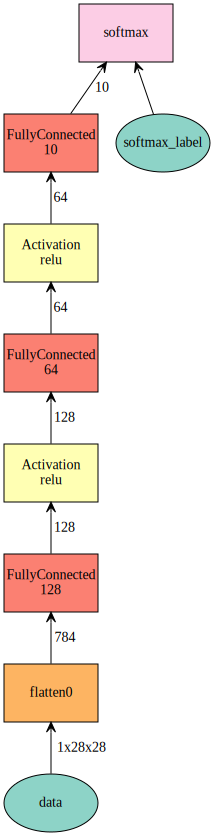

In [6]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [7]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  
/mxnet/python/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 29861.00 samples/sec	Train-accuracy=0.109650
INFO:root:Epoch[0] Batch [400]	Speed: 29010.23 samples/sec	Train-accuracy=0.109350
INFO:root:Epoch[0] Batch [600]	Speed: 29797.33 samples/sec	Train-accuracy=0.136650
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.142
INFO:root:Epoch[0] Validation-accuracy=0.259700
INFO:root:Epoch[1] Batch [200]	Speed: 32171.51 samples/sec	Train-accuracy=0.415900
INFO:root:Epoch[1] Batch [400]	Speed: 32950.13 samples/sec	Train-accuracy=0.746950
INFO:root:Epoch[1] Batch [600]	Speed: 30529.17 samp